## Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nltk
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, plot_precision_recall_curve

In [2]:
rootpath = r"~\OneDrive\Desktop\Programming\DS\datasets\nlp_getting_started"
train = pd.read_csv(rootpath + "/train.csv")
test = pd.read_csv(rootpath + "/test.csv")
sub = pd.read_csv(rootpath + "/sample_submission.csv")

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Preprocessing

In [4]:
train = train.drop(['keyword', 'location', 'id'], axis = 1)

In [5]:
train_df, test_df = train_test_split(train, test_size=0.2)

In [6]:
stop_words = stopwords.words("english")
snowball = SnowballStemmer(language="english")

def tokenize_sentence (sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="english")
    tokens = [i for i in tokens if i not in string.punctuation]          # removing punctuation
    if remove_stop_words:                                                # removing stop words
        tokens = [i for i in tokens if i not in stop_words]
    tokens = [snowball.stem(i) for i in tokens]                          # removing the endings
    return tokens

In [7]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words = True))

In [8]:
features = vectorizer.fit_transform(train_df["text"])

## Model

In [9]:
model = LogisticRegression(random_state=0)
model.fit(features, train_df["target"])

LogisticRegression(random_state=0)

In [10]:
# Simple model of Logistic Regression with vectorizer
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words = True))),
    ("model", LogisticRegression(random_state=0))
])
model_pipeline.fit(train_df["text"], train_df["target"])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000001DF0EF9AEE0>)),
                ('model', LogisticRegression(random_state=0))])

In [11]:
precision_score(y_true=test_df["target"], y_pred=model_pipeline.predict(test_df["text"])) 

0.817717206132879

In [12]:
recall_score(y_true=test_df["target"], y_pred=model_pipeline.predict(test_df["text"]))

0.7239819004524887

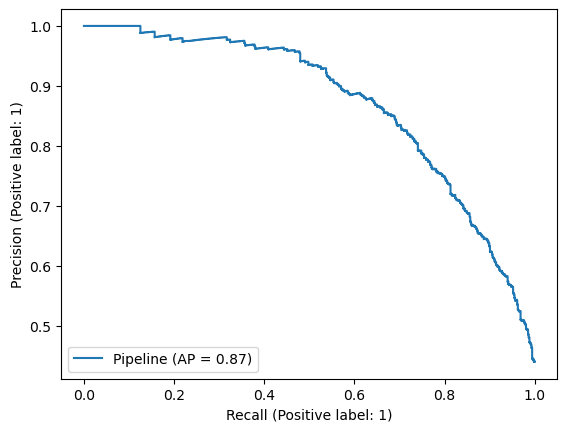

In [13]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["text"], y=test_df["target"])

In [16]:
# Upgrade the model using Huperparametrs
model_grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words = True))),
    ("model", 
     GridSearchCV(
         LogisticRegression(random_state=0),                       
         param_grid={'C' : [2, 2.05, 2.1]},
                    cv=5,
                    verbose=4))
])
model_grid_pipeline.fit(train_df["text"], train_df["target"])

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...............................C=2;, score=0.805 total time=   0.2s
[CV 2/5] END ...............................C=2;, score=0.802 total time=   0.0s
[CV 3/5] END ...............................C=2;, score=0.784 total time=   0.0s
[CV 4/5] END ...............................C=2;, score=0.775 total time=   0.0s
[CV 5/5] END ...............................C=2;, score=0.789 total time=   0.1s
[CV 1/5] END ............................C=2.05;, score=0.805 total time=   0.2s
[CV 2/5] END ............................C=2.05;, score=0.802 total time=   0.0s
[CV 3/5] END ............................C=2.05;, score=0.783 total time=   0.0s
[CV 4/5] END ............................C=2.05;, score=0.775 total time=   0.0s
[CV 5/5] END ............................C=2.05;, score=0.789 total time=   0.2s
[CV 1/5] END .............................C=2.1;, score=0.805 total time=   0.0s
[CV 2/5] END .............................C=2.1;,

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000001DF08467DC0>)),
                ('model',
                 GridSearchCV(cv=5,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [2, 2.05, 2.1]}, verbose=4))])

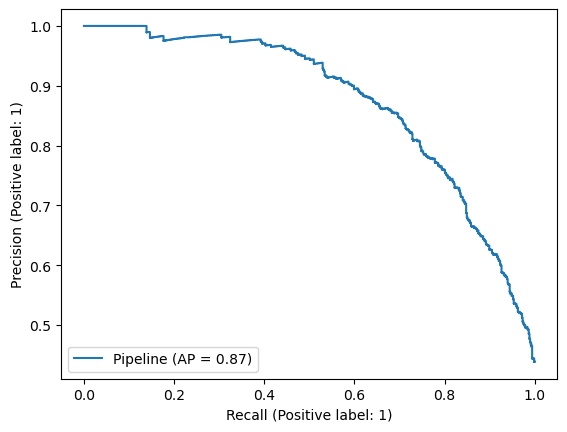

In [17]:
plot_precision_recall_curve(estimator=model_grid_pipeline, X=test_df["text"], y=test_df["target"])

In [18]:
precision_score(y_true=test_df["target"], y_pred=model_grid_pipeline.predict(test_df["text"]))

0.8089700996677741

In [19]:
recall_score(y_true=test_df["target"], y_pred=model_grid_pipeline.predict(test_df["text"]))

0.7345399698340875

## Submission

In [20]:
id_col = test['id']
test = test.drop(['keyword', 'location', 'id'], axis = 1)

In [21]:
submission_test_pred = model_grid_pipeline.predict(test["text"])

In [22]:
submission_df = pd.DataFrame({
                  "id": id_col, 
                  "target": submission_test_pred})

In [23]:
submission_df.to_csv(rootpath + "/submission.csv", index=False)